<a href="https://colab.research.google.com/github/aharrisonau/Task-4.2P/blob/main/Task_4_2P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 4.2P**
# **Monte Carlo Methods - Off Policy**

This code implementation is based on the code used for Practical 4 and has been modified to apply the off-policy method.

Modified code is indicated with comments

====================

In this workshop, we will play Blackjack using Monte Carlo methods. To do this, we will be using the Gym Blackjack-v0 environment. 

Recall that Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over. The game is played against a fixed dealer whereby cards are converted into numerical values as follows:

* Numbered cards are accounted for at their face value
* Face cards (Jack, Queen, King) have value of 10
* Aces can either count as 11 or 1 (called 'usable' at 11).

The game starts with dealer having one face up and one face down card, while the player has two face up cards. The player can request additional cards (hit=1) until they decide to stop (stick=0) or exceed 21 (bust).

After the player sticks, the dealer reveals their facedown card, and draws until their sum is 17 or greater.  If the dealer goes bust the player wins. If neither player nor dealer busts, the outcome is  decided by whose sum is closer to 21.  

In this environment, the reward for winning is +1, drawing is 0, and losing is -1.

As usual, we commence by installing the relevant packages.

In [1]:
import sys
import gym
import numpy as np
import random
from collections import defaultdict

episodes_to_run = 500000

And now, we proceed to construct the environment.

In [2]:
env = gym.make('Blackjack-v0')

# **Monte Carlo Prediction**



We now look at Monte Carlo prediction to play Blackjack. To do this, we start by defining a probability of random choice. 


In [3]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset() #here, bj_env is the env instance
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In the code below we obtain the average prediction using the Monte Carlo probabilities. Note the Q-table is actually an average over the episodes.
#4.2P Modification#
In addition to running the Monte Carlo methods from Practical 4, the methods have been modified to record the progression of values for a particular state.
The state followed is:
- player shows 18
- dealer shows 7
- usable ace = TRUE

We will use this progress to compare convergence for each method

In [4]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    ##########
    # 4.2P modification

    state_value_results = []

    #
    #########

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # Let us monitor our progress :)
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            
            
        # Generating an episode using our 80-20 policy we defined above:
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        '''
        This discounts array is the amount by which we wanna discount each consequent reward ie.
        discounts = [1,gamma, gamma^2, gamma^3.....] 
        then we compute the total return Gt= Rt+1 *1 + Rt+2 * gamma + Rt+3 * gamma^2 +...
        '''
        discounts = np.array([gamma**i for i in range(len(rewards)+1)]) 
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states): #ever-visit
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            #Just taking the mean of all the returns got by taking this action when we were in this state.
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
        
        ##########
        # 4.2P modification

        # track the value for the tracked state as it progresses
        state_value_results.append(np.dot([0.2,0.8],Q[(18, 7, True)]))

    return Q, np.asarray(state_value_results) # return the tracked results
        #
        #################

The line below just recovers the actual Q table using the code defined above

In [5]:
##########
# 4.2P modification

# obtain the action-value function
# also recover the array of stochastic results
Q, stochastic_results = mc_prediction_q(env, episodes_to_run, generate_episode_from_limit_stochastic)

#
#################

Episode 500000/500000.

We can now plot our results for the state-value function. Note we have divided these into a usable and an unusable ace.

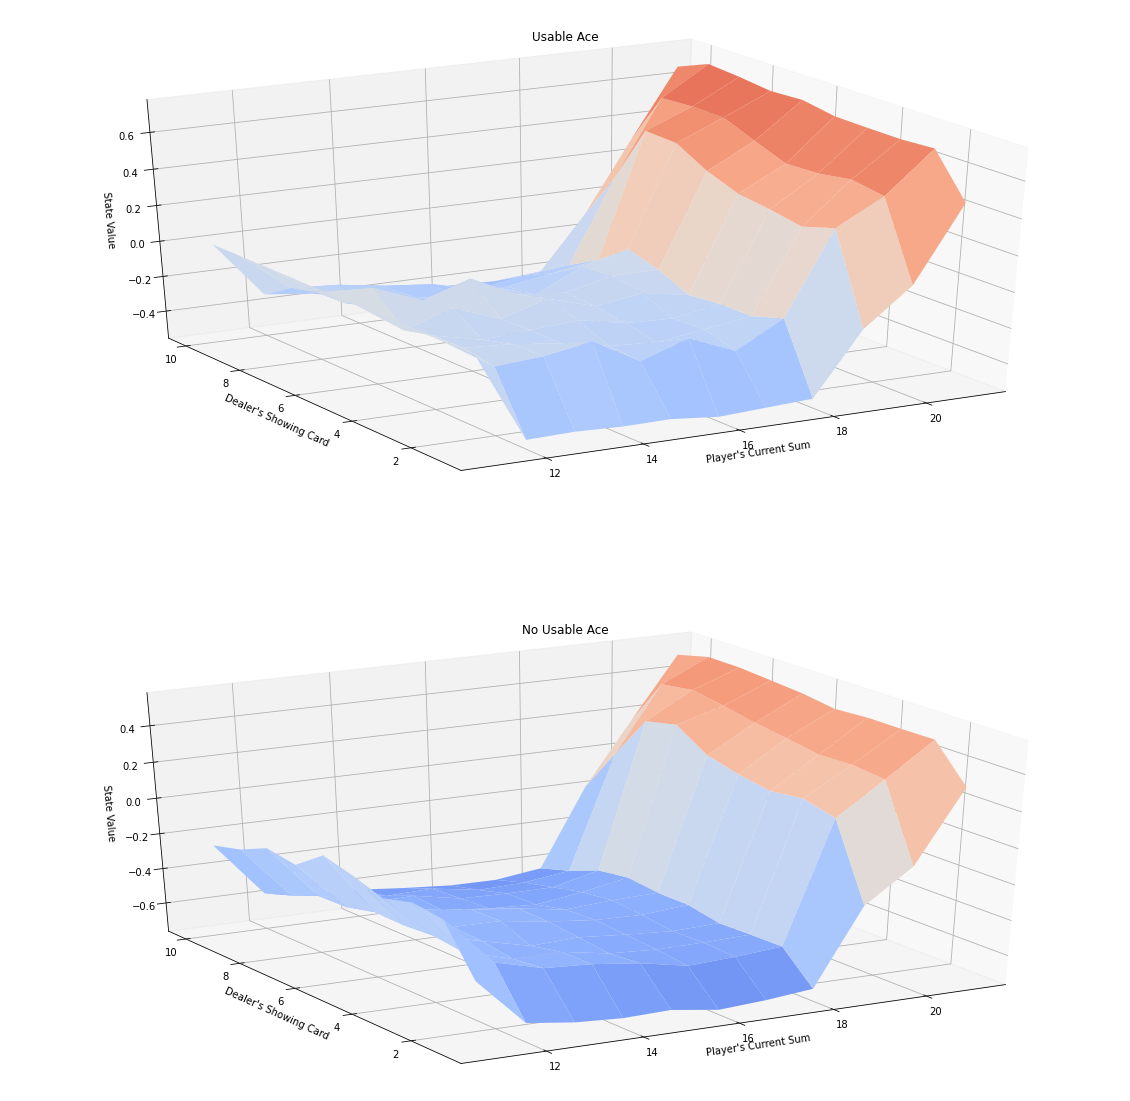

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()
    
# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)    

The episode then becomes an epsilon-greedy one over the state-value function we computed earlier instead of an stochastic policy.

In [7]:
def get_probs(Q_s, epsilon, nA): #nA is no. of actions in the action space
    # obtains the action probabilities corresponding to epsilon-greedy policy
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s
  
''' 
Now we will use this get_probs func in generating the episode. 
Note that we are no longer using the stochastic policy we started with, instead building upon it in an epsilon greedy way.
'''
def generate_episode_from_Q(env, Q, epsilon, nA):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

''' 
Finally Q values are approximated by taking average of corresponding returns.
But instead we can write it using incremental mean and constant alpha.
As we are using constant alpha we need not keep a track of N-table, ie how many times we visited that state.
''' 

def update_Q(env, episode, Q, alpha, gamma):
    # updates the action-value function estimate using the most recent episode 
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

Note the Monte Carlo control sequence below. this is the actual implementation of the epsilon-greedy approach and the action-value updates at each episode.

In [8]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    
    ##########
    # 4.2P modification

    state_value_results = []

    #
    #########

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
        
        ##########
        # 4.2P modification

        # track the value for the tracked state as it progresses
        state_value_results.append(np.max(Q[(18, 7, True)])) 
                                          
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, np.asarray(state_value_results) # return the tracked results
        #
        #################

With all the definitions in hand, we can obtain the policy and state-value functions. We also plot the values.

Episode 500000/500000.

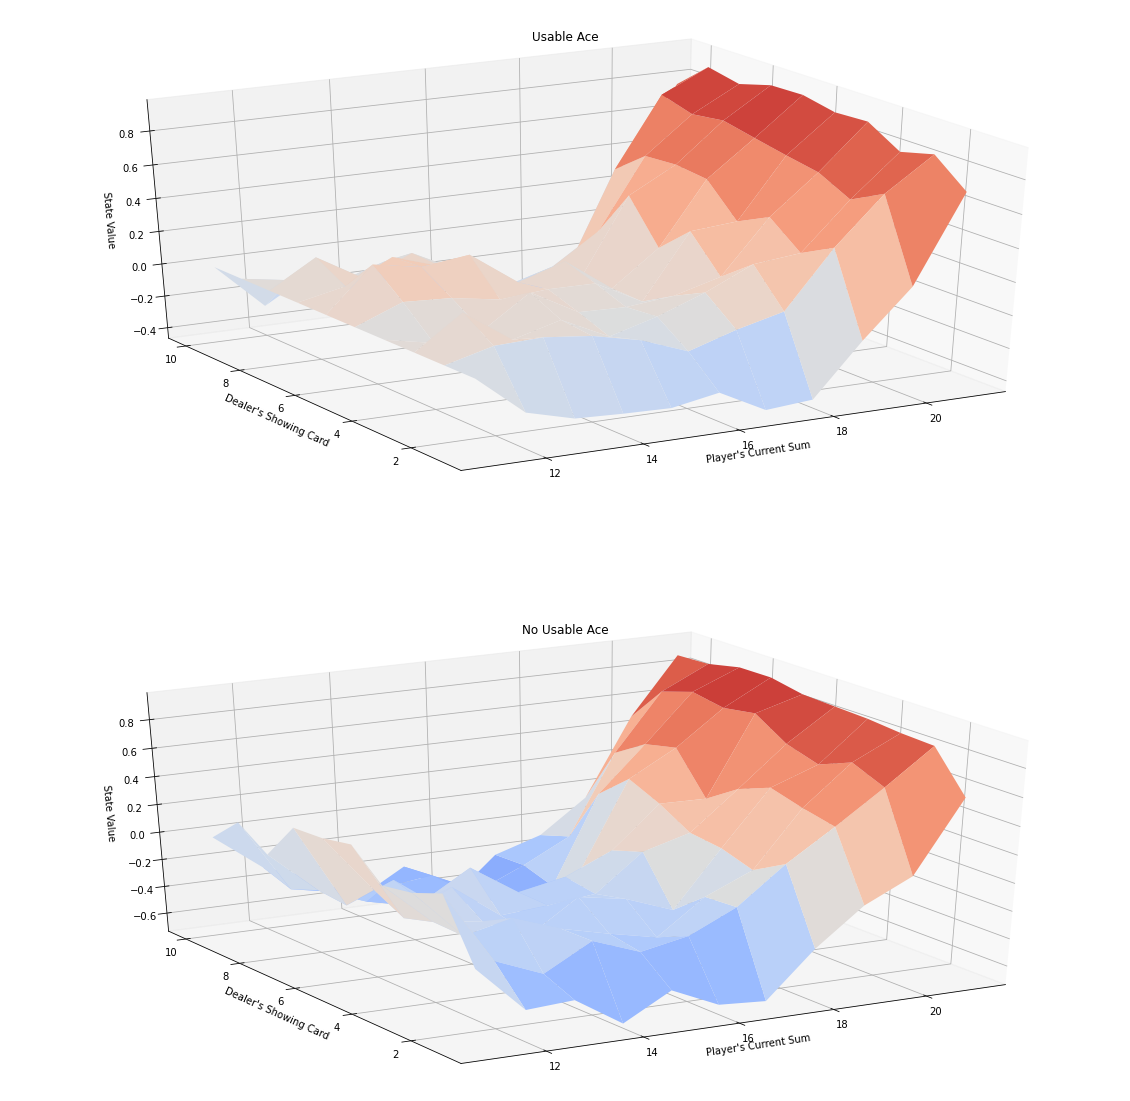

In [9]:
##########
# 4.2P modification

# obtain the estimated optimal policy and action-value function
# also recover the array of results for the e-greedy method
policy, Q, e_greedy_results = mc_control(env, episodes_to_run, 0.015)

#
#################

# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we plot the policy

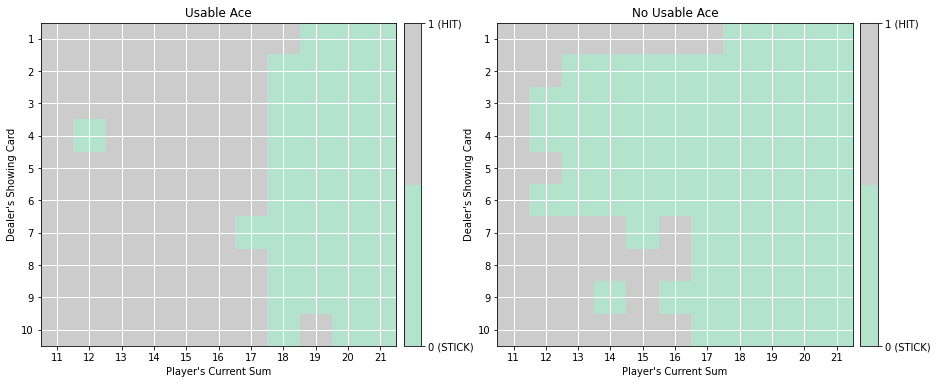

In [10]:
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

# plot the policy
plot_policy(policy)

# **Task 4.2P - Implement off-policy method** #

The remaining code is new code, adapted from Practical 4.  In this code, the methods of Practical 4 are combined to provide an Off-Policy method.

The behaviour policy will be a stochastic policy with a random 50:50 split between HIT and STICK

Episodes will be generated from this policy and the results will be used to update the Q table for the target policy.

To do this, an additional table of importance-sampling ratio weights must also be kept and updated

In [11]:
# define a function to generate a random episode, with 50:50 hit:stick

def generate_episode_50_50(bj_env):
    episode = []
    state = bj_env.reset() #here, bj_env is the env instance
    while True:
        probs = [0.5, 0.5]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Define a function that will update the Q table and the cumulative weights

This follows the method of Sutton and Barto (2020)

In [19]:
def update_Q_C_policy(env, episode, Q, C, policy, gamma):
    # updates the action-value function estimate using the most recent episode
    # also updates the cumulative sum of weights 
    states, actions, rewards = zip(*episode)
    # initialize the weights and rewards
    G = 0.0
    W = 1.0
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in reversed(list(enumerate(states))):
        G = gamma * G + rewards[i]
        C[state][actions[i]] = C[state][actions[i]] + W
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + (W / C[state][actions[i]]) *(G - old_Q)
        policy[state] = np.argmax(Q[state])
        if policy[state] == Q[state][actions[i]]:
          break
        W = W * (1 / 0.5)
    return Q, C, policy

Next we define the procedure for iterating all the required episodes

In [13]:
def mc_off_policy_q(env, num_episodes, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    C = defaultdict(lambda: np.zeros(nA))
    policy = defaultdict(lambda: 0)
    state_value_results = []
   
    # loop over episodes
    for i_episode in range( 1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # generate an episode by following the 50-50 behaviour policy
        episode = generate_episode_50_50(env)
        # update the action-value function estimate using the off policy episode
        Q, C, policy = update_Q_C_policy(env, episode, Q, C, policy, gamma)
        state_value_results.append(np.max(Q[(18, 7, True)]))

    return policy, Q, np.asarray(state_value_results) # return the tracked results

Lastly, use the defined functions to run the off-policy method

Episode 500000/500000.

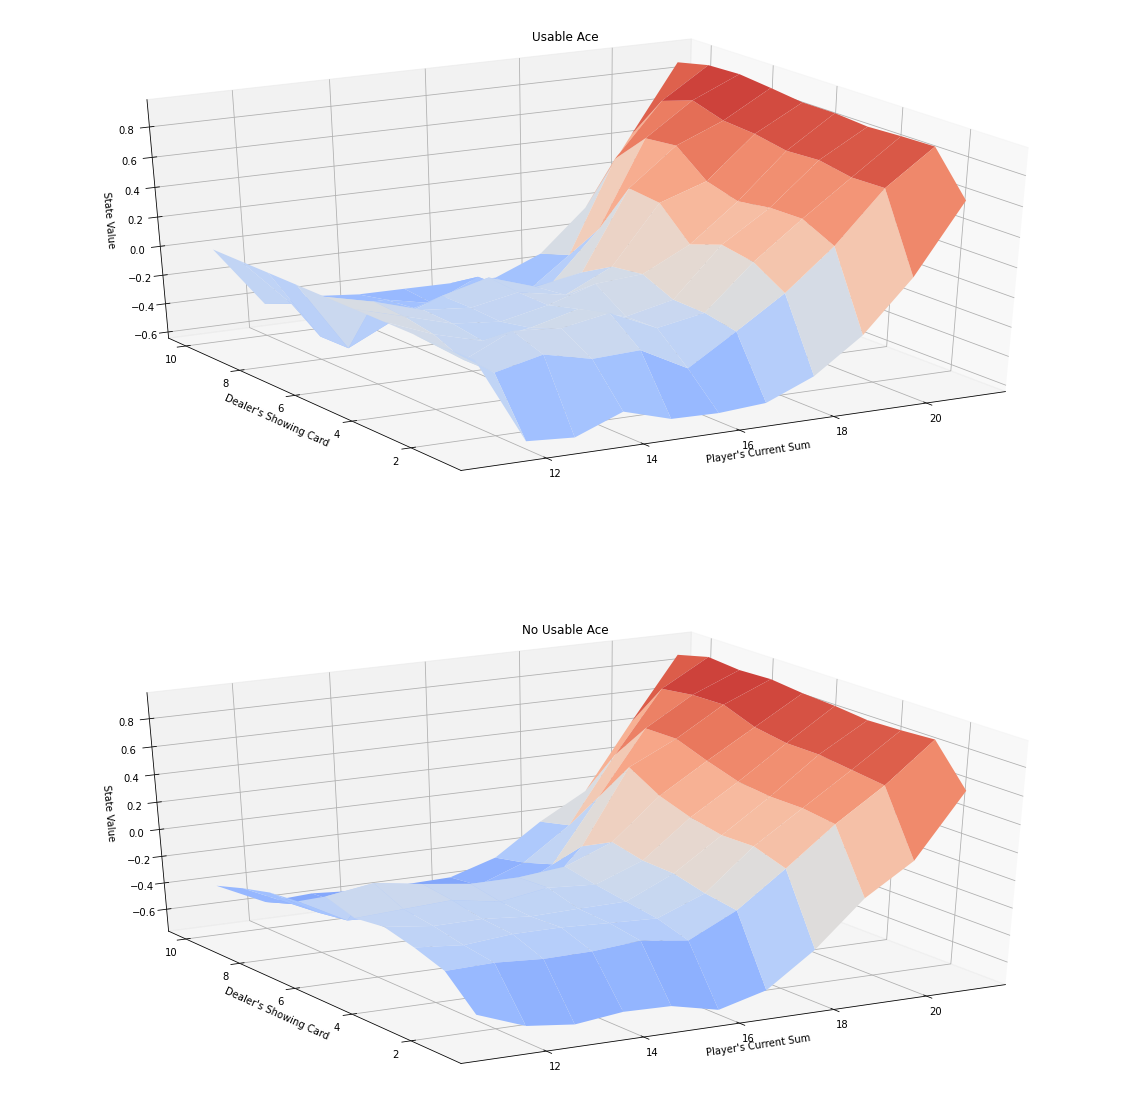

In [20]:
# obtain the estimated optimal policy and action-value function
policy, Q, off_policy_results = mc_off_policy_q(env, episodes_to_run)

# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we plot the convergence traces for the three different methods

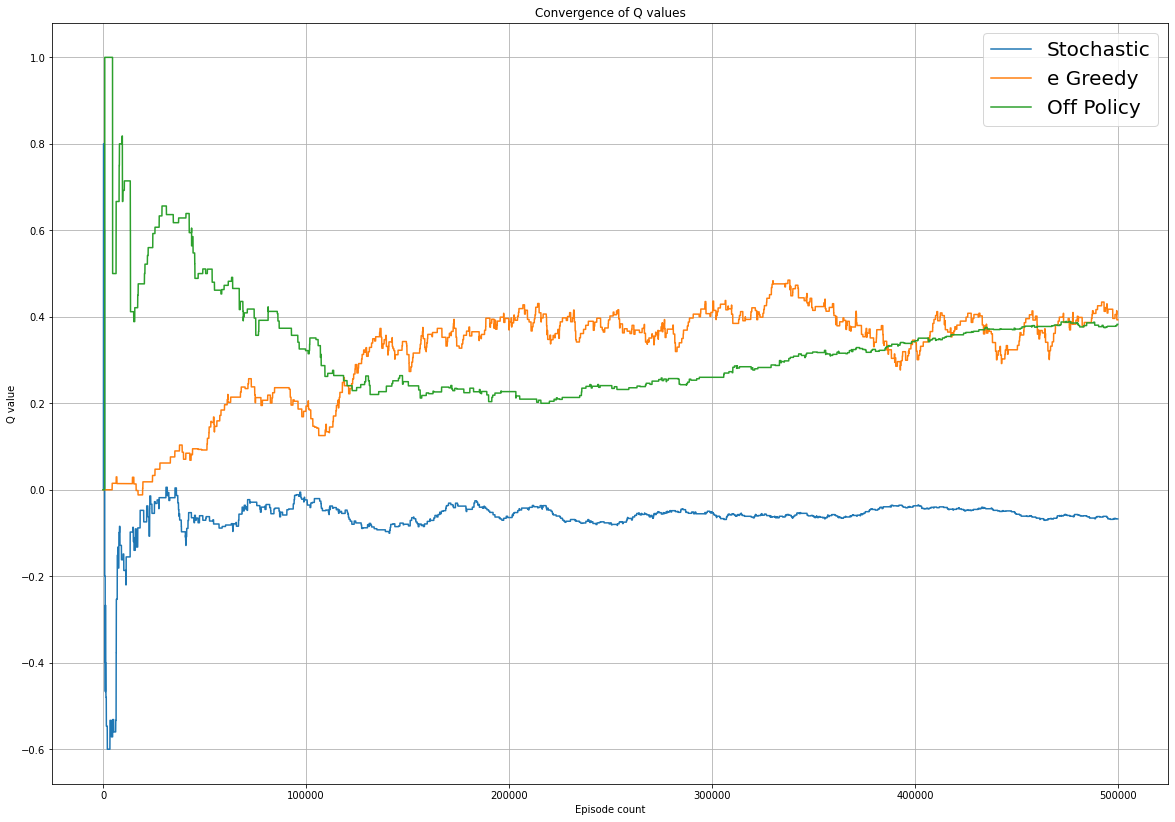

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
fig.set_size_inches(20, 14)
ax.plot(range(len(stochastic_results)), stochastic_results, label="Stochastic")
ax.plot(range(len(e_greedy_results)), e_greedy_results, label="e Greedy")
ax.plot(range(len(off_policy_results)), off_policy_results, label="Off Policy")

ax.set(xlabel='Episode count', ylabel='Q value',
       title='Convergence of Q values')
ax.grid()
ax.legend(fontsize=20)

plt.show()